[   14   240   462   679   899  1340  1557  1764  1988  2647  2868  3091
  3314  3532  3744  3969  4188  4406  4622  4841  5063  5502  5721  5943
  6158  6381  6598  6818  7034  7254  7476  7689  7916  8137  8355  8573
  8788  9013  9233  9451  9669  9889 10110 10329 10547 10768 10989 11208
 11422 11646 11866 12086 12299 12522 12740 12960 13179 13391 13616 13833
 14062 14283 14501 14720 14940 15152 15372 15587 15808 16029 16244 16469
 16690 16916 17131 17353 17563 17782 18008 18225 18440 18661 18884 19106
 19323 19541 19757 19984 20203 20418 20632 20860 21080 21298 21515 21734
 21956 22174 22391 22604 22832 23055 23276 23495 23714 23935 24151 24367
 24580 24798 25019 25240 25461 25686 25912 26135 26354 26569 26777 26994
 27210 27426 27642 27869 28093 28320 28546 28767 28984 29200 29415 29629
 29841 30058 30279 30505 30722 30949 31173 31391 31614 31828 32041 32257
 32477 32697 32913 33135 33362 33587 33805 34021 34240 34461 34676 34888
 35104 35330 35554 35775 35992 36208 36437 36655 36

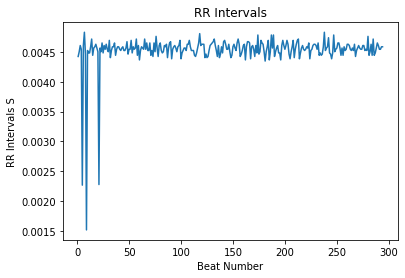

[  0. 226. 222. 217. 220. 441. 217. 207. 224. 659. 221. 223. 223. 218.
 212. 225. 219. 218. 216. 219. 222. 439. 219. 222. 215. 223. 217. 220.
 216. 220. 222. 213. 227. 221. 218. 218. 215. 225. 220. 218. 218. 220.
 221. 219. 218. 221. 221. 219. 214. 224. 220. 220. 213. 223. 218. 220.
 219. 212. 225. 217. 229. 221. 218. 219. 220. 212. 220. 215. 221. 221.
 215. 225. 221. 226. 215. 222. 210. 219. 226. 217. 215. 221. 223. 222.
 217. 218. 216. 227. 219. 215. 214. 228. 220. 218. 217. 219. 222. 218.
 217. 213. 228. 223. 221. 219. 219. 221. 216. 216. 213. 218. 221. 221.
 221. 225. 226. 223. 219. 215. 208. 217. 216. 216. 216. 227. 224. 227.
 226. 221. 217. 216. 215. 214. 212. 217. 221. 226. 217. 227. 224. 218.
 223. 214. 213. 216. 220. 220. 216. 222. 227. 225. 218. 216. 219. 221.
 215. 212. 216. 226. 224. 221. 217. 216. 229. 218. 214. 214. 215. 228.
 218. 217. 220. 226. 217. 223. 209. 224. 222. 213. 215. 216. 222. 230.
 222. 218. 213. 229. 222. 209. 219. 209. 226. 222. 219. 217. 223. 223.
 229. 

In [89]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import find_peaks


data = pd.read_csv('dataN.txt', header = None)
data2 = pd.read_csv('data2.txt', header = None)


def NotchFilter(data):
    fs = 256.0  # Sample frequency (Hz)
    f0 = 50.0  # Frequency to be removed from signal (Hz)
    Q =  30  # Quality factor
    w0 = f0 / (fs / 2 )  # Normalized Frequency
    b, a = signal.iirnotch(f0,Q,fs )
    data = signal.filtfilt(b, a, data,axis=0)
    return data


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(1, [low, high], btype='band')
    return b, a
def Bandpass(data):
    b, a = butter_bandpass(0.1, 45, 256)
    y = signal.filtfilt(b, a, data,axis=0)
    return y
#plt.figure(figsize=(15,10)) 

def Filter(data):
    NotchFiltered=NotchFilter(data);
    BandFiltered=Bandpass(NotchFiltered);
    return BandFiltered;

'''
plt.plot(data[0:2000])
plt.show()
#NotchFiltered=NotchFilter(data);

#plt.plot(NotchFiltered[0:2000])
#plt.show()

#BandFiltered=Bandpass(NotchFiltered);
#print(data)
BandFiltered=Filter(data)
plt.plot(BandFiltered[0:2000])
plt.show()
'''



def differentiate(BandFiltered):
    NewArray =np.copy(BandFiltered)
    for i in range(4, len(BandFiltered)-2):
        #print(NewArray[i])
        NewArray[i]=(-1*BandFiltered[i-2]-2*BandFiltered[i-1]+1*BandFiltered[i+2]+2*BandFiltered[i+1])
    return NewArray

def Square(differentiated):
    return np.square(differentiated)


def SmoothWithWindow(data,Window=25):
    Filtered=Filter(data)
    Filtered=differentiate(Filtered)
    squared=Square(Filtered)
    NewArray =np.copy(squared)
    for i in range(0,len(squared)):
        NewArray[i]=0
        for j in range(0,Window):
            NewArray[i]+=squared[i-j]
    return NewArray

    
def SkipFilter(data,Window=25):
    Filtered=differentiate(data)
    squared=Square(Filtered)
    NewArray =np.copy(squared)
    for i in range(0,len(squared)):
        NewArray[i]=0
        for j in range(0,Window):
            NewArray[i]+=squared[i-j]
    return NewArray
    

'''        
plt.xlabel('Samples')
plt.ylabel('Voltage')
 
smoothed=SmoothWithWindow(squared,Window=5)
plt.plot(smoothed[0:2000])
plt.title('Smoothed Signal with N = 5')
plt.xlabel('Samples')
plt.ylabel('Voltage')
 

plt.show()
plt.xlabel('Samples')
plt.ylabel('Voltage')
 
smoothed=SmoothWithWindow(squared,Window=15)
plt.plot(smoothed[0:2000])
plt.title('Smoothed Signal with N = 15')

plt.show()
plt.xlabel('Samples')
plt.ylabel('Voltage')
'''

def RRIntervals(data,Window=25):
    smoothed=SmoothWithWindow(data)
    ThresholdRpeak=(0.75-(1/15))*np.max(smoothed)
    peaks, _ = find_peaks(smoothed.flatten(),height=ThresholdRpeak, distance=200)
    print(peaks)
    BeatNumber=np.zeros(len(peaks))
    RR=np.zeros(len(peaks))
    FF=np.zeros(len(peaks))
    for i in range(1,len(peaks)):
        BeatNumber[i]=i
        FF[i]=peaks[i]-peaks[i-1]
        RR[i]=1/FF[i]
    RR=RR[1:]
    BeatNumber=BeatNumber[1:]
    plt.plot(BeatNumber, RR)  
    plt.title('RR Intervals')
    plt.ylabel('RR Intervals S')
    plt.xlabel('Beat Number')
    plt.show()
    return FF,peaks


    
    
    

def Plot(smoothed,title,Window=25):
    ThresholdRpeak=(0.75-(1/15))*np.max(smoothed)
    print(ThresholdRpeak)
    peaks, _ = find_peaks(smoothed[0:2000].flatten(),height=ThresholdRpeak, distance=200)
    plt.plot(smoothed[0:2000])
    plt.plot(peaks, smoothed[peaks], "x")
    plt.title(title)
    plt.show()
    
#smoothed=SmoothWithWindow(data,Window=25)
#Plot(smoothed,"Smoothed, Filted , N=25 ")

#RRIntervals(data)
      
def MissingBeats(data,Window=25):
    Intervals,peaks=RRIntervals(data,Window)
    Smoothed=SmoothWithWindow(data,Window)
    average= np.average(Intervals)
    print(Intervals)
    print(average)
    for i in range(1,len(peaks)):
        difference=peaks[i]-peaks[i-1]
        #print(difference)
        if(difference>average*1.75):
            print("Missing Beat At")
            print((peaks[i]+peaks[i-1])/(2*256))

'''
SkipFilter =SkipFilter(data[0])
Plot(SkipFilter,"Smoothed, Not Filted , N=25 ")
'''



'''
MissingBeats=SmoothWithWindow(data2,Window=25)
Plot(MissingBeats,"Smoothed, Filted , N=25 ")
'''
MissingBeats(data2,Window=25)